# Mr Haulage Order Forecasting

Contained in this notebook are the forecasting methods used to predict orders over the next two years

### Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import datetime
from pandas.plotting import autocorrelation_plot
from prophet import Prophet
from prophet.plot import plot_yearly

Importing plotly failed. Interactive plots will not work.


### Data Loading

In [2]:
orders = pd.read_csv("../data/clean/orders.csv")

orders.head()

,Order Date,Large,Small,Total,Moving Average,Small Moving Average,Large Moving Average
0,2021-08-22,0,6,6,NaN,NaN,NaN
1,2021-08-23,3,4,7,NaN,NaN,NaN
2,2021-08-24,3,7,10,NaN,NaN,NaN
3,2021-08-25,1,6,7,NaN,NaN,NaN
4,2021-08-26,3,3,6,NaN,NaN,NaN


### Parameter Selection

In order for ARIMA modelling to be effective, we first check if the data is stationary.

In [3]:
#Calculate the ADF statistic
total_adf = adfuller(orders["Total"])

#Print the statistic
print('ADF Statistic: %f' % total_adf[0])

#Print the p-value for testing
print('p-value: %f' % total_adf[1])

#Print the corresponding critical values
print('Critical Values:')

#For loop to print these values
for key, value in total_adf[4].items():
     print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.327565
p-value: 0.013690
Critical Values:
	1%: -3.442
	5%: -2.866
	10%: -2.569


Here we conducted a small hypothesis test, and we see that our data appears to be stationary.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

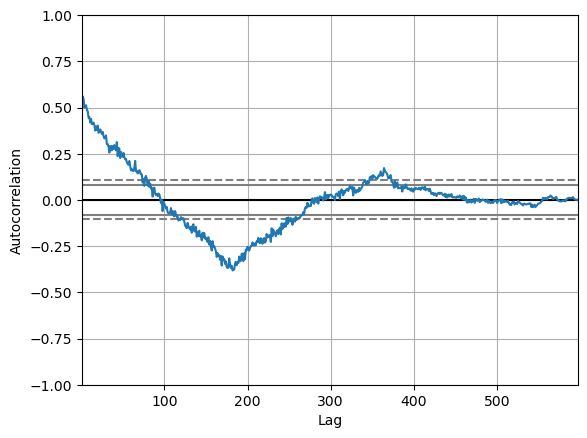

In [4]:
autocorrelation_plot(orders["Total"])

We see that there appears to be a significant autocorrelation up until lags of about 75, so we will use this to inform our parameters.

### Large Box Forecast

We next manipulate our data for ease of use in prophet.

In [5]:
large_prophet_data = orders.loc[:,['Order Date', 'Large']]
large_prophet_data = pd.DataFrame(large_prophet_data).rename(columns = {'Large': 'y', 'Order Date': 'ds'}) 

Finally, we fit a model and forecast the next two years. We have chose a seasionality of 3 since this gives the best balance for out of sample fit.

13:08:40 - cmdstanpy - INFO - Chain [1] start processing
13:08:41 - cmdstanpy - INFO - Chain [1] done processing


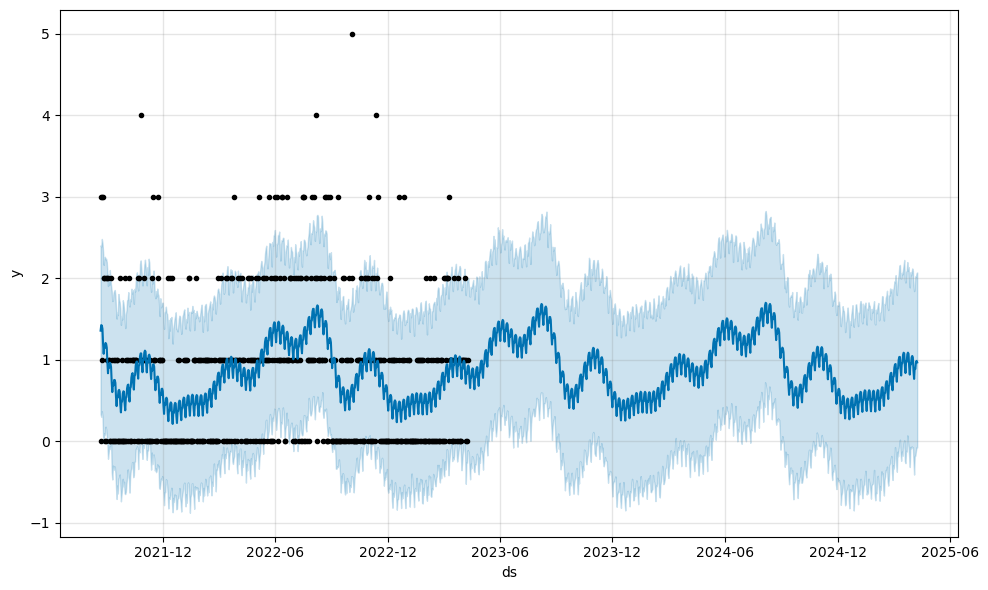

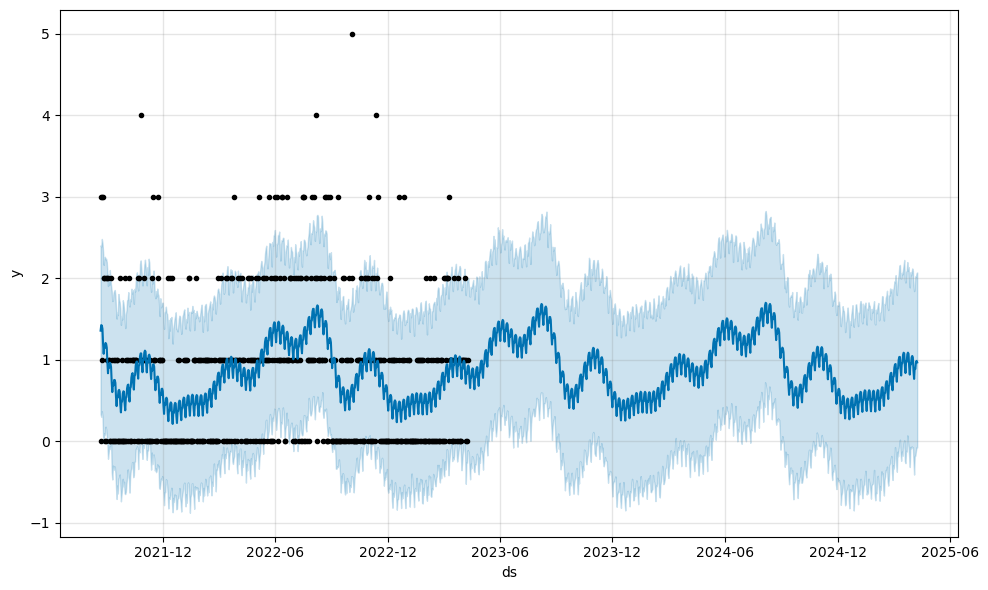

In [6]:
ml = Prophet(yearly_seasonality = 5)
ml.fit(large_prophet_data)
futurel = ml.make_future_dataframe(periods=730)
forecastl = ml.predict(futurel)
ml.plot(forecastl)

We next want to trim our dataframe to only include the relevant values.

In [7]:
lpred = forecastl.loc[597:,["ds", 'yhat_upper', 'yhat']]

And round to nearest integers, since this is a counting time series problem

In [8]:
lpred["yhat"] = lpred["yhat"].round()
lpred["yhat_upper"] = lpred["yhat_upper"].round()

In [9]:
lpred.head()

,ds,yhat_upper,yhat
597,2023-04-11,2.0,1.0
598,2023-04-12,2.0,1.0
599,2023-04-13,2.0,1.0
600,2023-04-14,2.0,1.0
601,2023-04-15,2.0,1.0


### Small Box Forecast

We now do the same for the small boxes.

13:08:42 - cmdstanpy - INFO - Chain [1] start processing
13:08:42 - cmdstanpy - INFO - Chain [1] done processing


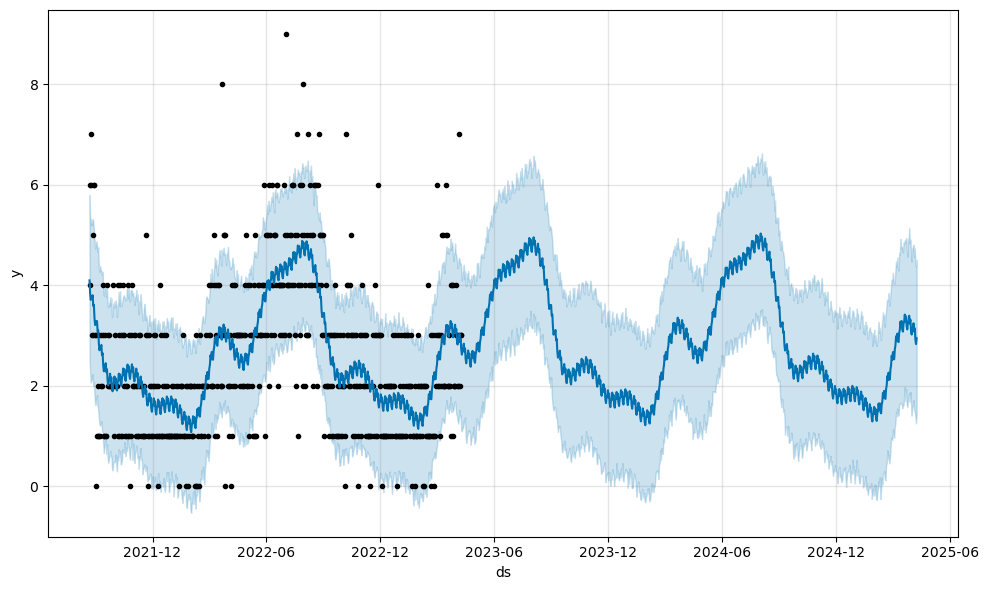

In [10]:
small_prophet_data = orders.loc[:,['Order Date', 'Small']]
small_prophet_data = pd.DataFrame(small_prophet_data).rename(columns = {'Small': 'y', 'Order Date': 'ds'}) 

ms = Prophet(yearly_seasonality = 5)
ms.fit(small_prophet_data)
futures = ms.make_future_dataframe(periods=730)
forecasts = ms.predict(futures)
ms.plot(forecasts)

spred = forecasts.loc[597:,["ds", 'yhat_upper', 'yhat']]

spred["yhat"] = spred["yhat"].round()
spred["yhat_upper"] = spred["yhat_upper"].round()

In [11]:
spred.head()

,ds,yhat_upper,yhat
597,2023-04-11,4.0,3.0
598,2023-04-12,4.0,3.0
599,2023-04-13,4.0,3.0
600,2023-04-14,4.0,3.0
601,2023-04-15,4.0,3.0


### Save Data

Since this model is based on count data, we will now round our predictions to the nearest integer, and save the data.

In [13]:
lpred.to_csv('../data/forecast/Large Box Forecast.csv', index=True)
spred.to_csv('../data/forecast/Small Box Forecast.csv', index=True)

### Further Calculations

We can calculate our expected profits from these forecasts, which will be used to calculate profits and such. So we have that a small box delivers a profit of 20, and a large box delivers a profit of 100.

In [1]:
p_l = 100
p_s = 20

Then we simply sum all the orders across the 2 years and multiply by their respective profits.

In [16]:
total_large_profit = p_l*(lpred["yhat"].sum())

print(total_large_profit)

68800.0


In [18]:
total_small_profit = p_s*(spred["yhat"].sum())

print(total_small_profit)

42360.0


We also do this for the upper bounds on the expected orders.

In [19]:
upper_total_large_profit = p_l*(lpred["yhat_upper"].sum())

print(upper_total_large_profit)

upper_total_small_profit = p_s*(spred["yhat_upper"].sum())

print(upper_total_small_profit)

148400.0
64460.0
